In [1]:
from pytorch_transformers import GPT2Tokenizer
from experiment import Intervention, Model
from attention_utils import report_intervention, report_interventions

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = Model(output_attentions=True)

In [3]:
# Test experiment
intervention1 = Intervention(
        tokenizer,
        "The doctor asked the nurse a question. {}",
        ["He", "She"],
        ["asked", "answered"])

intervention2 = Intervention(
        tokenizer,
        "The doctor asked the nurse a question. {}",
        ["He", "She"],
        ["requested", "responded"])

intervention3 = Intervention(
        tokenizer,
        "The man felt sorry about what he said to the woman. {}",
        ["He", "She"],
        ["apologized", "forgave"])

intervention4 = Intervention(
        tokenizer,
        "The nurse notified the patient that {}",
        ["her", "his"],
        ["shift", "blood"])

100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Effect: INDIRECT
Intervention: replace Attn(x) with Attn(x') in a specific layer/head
x : The doctor asked the nurse a question. He
x': The doctor asked the nurse a question. She
Input value: x
Continuations compared: asked / answered
p(answered|x) / p(asked|x) = 0.06125
p(answered|x') / p(asked|x') = 0.37261
Total Effect: p(answered|x') / p(asked|x') / p(answered|x) / p(asked|x) = 6.084
Indirect Effect (p("answered"|x, Attn(x')) / p("asked"|x, Attn(x')) / (p("answered"|x) / p("asked"|x)):


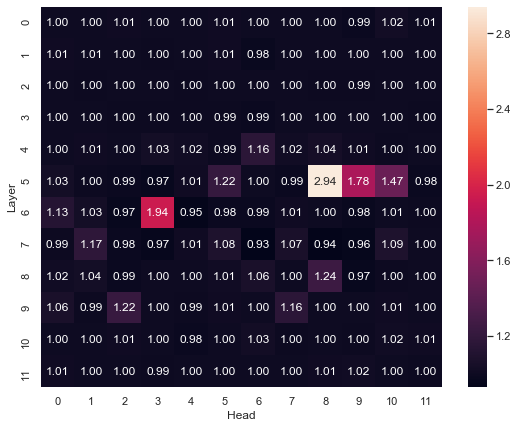

In [4]:
report_intervention(intervention1, 'indirect', model)

100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Effect: DIRECT
Intervention: replace x with x' while preserving Attn(x) in a specific layer/head
x : The doctor asked the nurse a question. He
x': The doctor asked the nurse a question. She
Input value: x
Continuations compared: asked / answered
p(answered|x) / p(asked|x) = 0.06125
p(answered|x') / p(asked|x') = 0.37261
Total Effect: p(answered|x') / p(asked|x') / p(answered|x) / p(asked|x) = 6.084
Direct Effect: (p("answered"|x', Attn(x)) / p("asked"|x', Attn(x) / (p("answered"|x) / p("asked"|x)) =


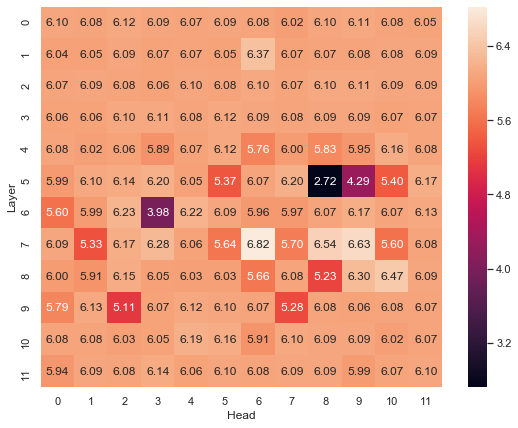

In [5]:
report_intervention(intervention1, 'direct', model)

100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Effect: INDIRECT
Intervention: replace Attn(x) with Attn(x') in a specific layer/head
x : The doctor asked the nurse a question. He
x': The doctor asked the nurse a question. She
Input value: x
Continuations compared: requested / responded
p(responded|x) / p(requested|x) = 5.60562
p(responded|x') / p(requested|x') = 48.40155
Total Effect: p(responded|x') / p(requested|x') / p(responded|x) / p(requested|x) = 8.634
Indirect Effect (p("responded"|x, Attn(x')) / p("requested"|x, Attn(x')) / (p("responded"|x) / p("requested"|x)):


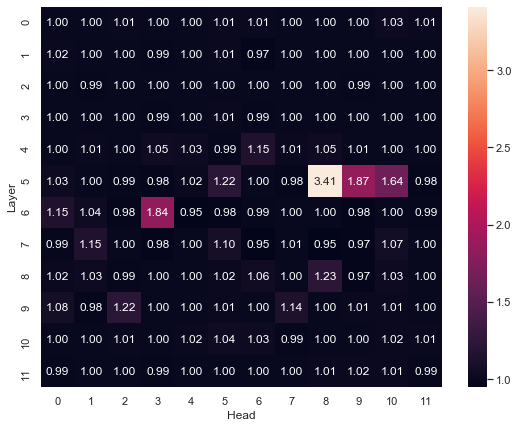

In [6]:
report_intervention(intervention2, 'indirect', model)

100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


Effect: DIRECT
Intervention: replace x with x' while preserving Attn(x) in a specific layer/head
x : The doctor asked the nurse a question. He
x': The doctor asked the nurse a question. She
Input value: x
Continuations compared: requested / responded
p(responded|x) / p(requested|x) = 5.60562
p(responded|x') / p(requested|x') = 48.40155
Total Effect: p(responded|x') / p(requested|x') / p(responded|x) / p(requested|x) = 8.634
Direct Effect: (p("responded"|x', Attn(x)) / p("requested"|x', Attn(x) / (p("responded"|x) / p("requested"|x)) =


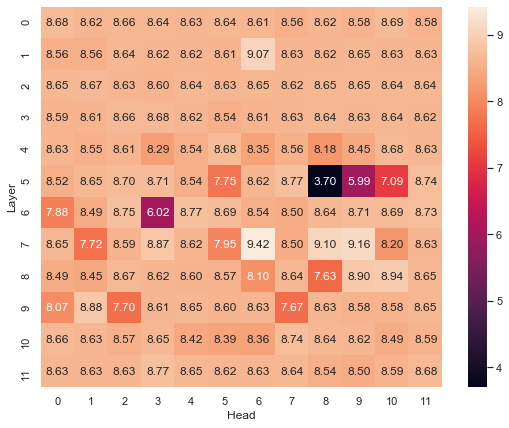

In [7]:
report_intervention(intervention2, 'direct', model)

100%|██████████| 12/12 [00:18<00:00,  1.50s/it]


Effect: INDIRECT
Intervention: replace Attn(x) with Attn(x') in a specific layer/head
x : The man felt sorry about what he said to the woman. He
x': The man felt sorry about what he said to the woman. She
Input value: x
Continuations compared: apologized / forg ave
p(forg ave|x) / p(apologized|x) = 1.22404
p(forg ave|x') / p(apologized|x') = 3.17622
Total Effect: p(forg ave|x') / p(apologized|x') / p(forg ave|x) / p(apologized|x) = 2.595
Indirect Effect (p("forg ave"|x, Attn(x')) / p("apologized"|x, Attn(x')) / (p("forg ave"|x) / p("apologized"|x)):


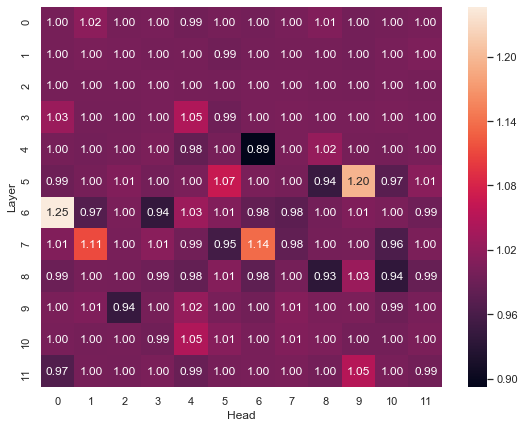

In [8]:
report_intervention(intervention3, 'indirect', model)

100%|██████████| 12/12 [00:15<00:00,  1.33s/it]


Effect: DIRECT
Intervention: replace x with x' while preserving Attn(x) in a specific layer/head
x : The man felt sorry about what he said to the woman. He
x': The man felt sorry about what he said to the woman. She
Input value: x
Continuations compared: apologized / forg ave
p(forg ave|x) / p(apologized|x) = 1.22404
p(forg ave|x') / p(apologized|x') = 3.17622
Total Effect: p(forg ave|x') / p(apologized|x') / p(forg ave|x) / p(apologized|x) = 2.595
Direct Effect: (p("forg ave"|x', Attn(x)) / p("apologized"|x', Attn(x) / (p("forg ave"|x) / p("apologized"|x)) =


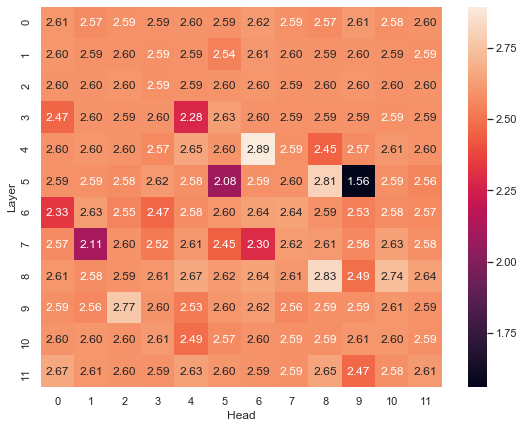

In [9]:
report_intervention(intervention3, 'direct', model)

100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Effect: INDIRECT
Intervention: replace Attn(x) with Attn(x') in a specific layer/head
x : The nurse notified the patient that her
x': The nurse notified the patient that his
Input value: x
Continuations compared: shift / blood
p(blood|x) / p(shift|x) = 41.54527
p(blood|x') / p(shift|x') = 102.70793
Total Effect: p(blood|x') / p(shift|x') / p(blood|x) / p(shift|x) = 2.472
Indirect Effect (p("blood"|x, Attn(x')) / p("shift"|x, Attn(x')) / (p("blood"|x) / p("shift"|x)):


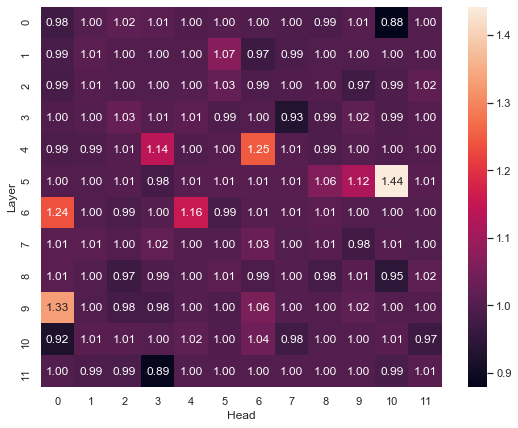

In [10]:
report_intervention(intervention4, 'indirect', model)

100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Effect: DIRECT
Intervention: replace x with x' while preserving Attn(x) in a specific layer/head
x : The nurse notified the patient that her
x': The nurse notified the patient that his
Input value: x
Continuations compared: shift / blood
p(blood|x) / p(shift|x) = 41.54527
p(blood|x') / p(shift|x') = 102.70793
Total Effect: p(blood|x') / p(shift|x') / p(blood|x) / p(shift|x) = 2.472
Direct Effect: (p("blood"|x', Attn(x)) / p("shift"|x', Attn(x) / (p("blood"|x) / p("shift"|x)) =


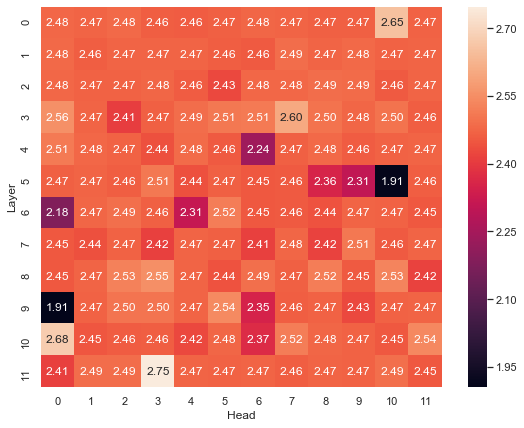

In [11]:
report_intervention(intervention4, 'direct', model)

100%|██████████| 12/12 [00:07<00:00,  1.60it/s]


*** SUMMARY ***
Effect: INDIRECT
Intervention: replace Attn(x) with Attn(x') in a specific layer/head
Num interventions: 4
Mean total effect: 4.95
Mean indirect effect:


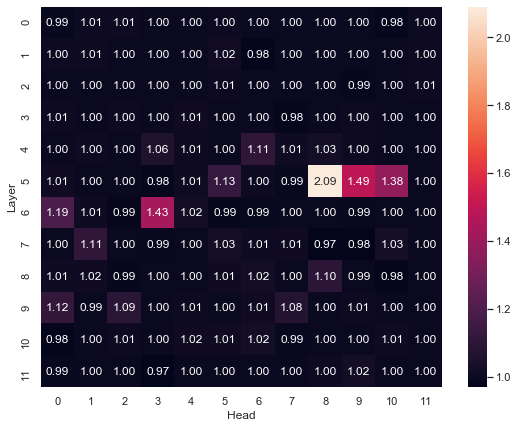

In [12]:
report_interventions([intervention1, intervention2, intervention3, intervention4], 'indirect', model)

100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


*** SUMMARY ***
Effect: DIRECT
Intervention: replace x with x' while preserving Attn(x) in a specific layer/head
Num interventions: 4
Mean total effect: 4.95
Mean direct effect:


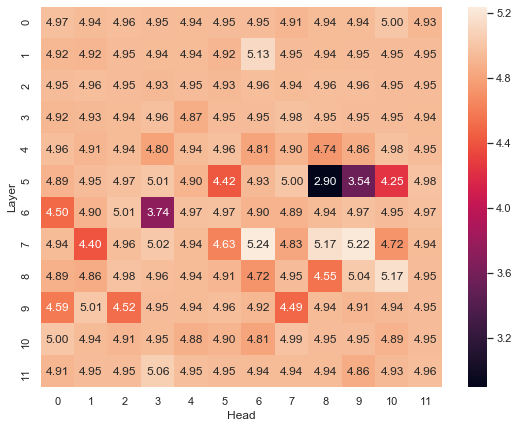

In [13]:
report_interventions([intervention1, intervention2, intervention3, intervention4], 'direct', model)


